In [104]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# ImageDataGenerator

- 이미지를 변형하여 추가적인 이미지들 생성
> 이미지 배열 데이터의 값 변환
> 이미지의 변형 처리


In [105]:
ori_image=plt.imread('tower.jpg')

In [106]:
ori_image=cv2.resize(ori_image,(200,400))

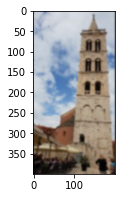

In [107]:
plt.figure(figsize=(4,3))
plt.imshow(ori_image)
plt.show()

In [108]:
datagen=tf.keras.preprocessing.image.ImageDataGenerator(
                            rotation_range=30,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            horizontal_flip=True)

In [8]:
towers=[]
while len(towers)<32:
    out=datagen.random_transform(ori_image)
    towers.append(out)

## 복제 이미지들 예시

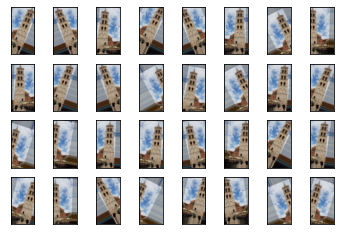

In [10]:
for i in range(32):
    plt.subplot(4,8,i+1)
    plt.gca().axes.yaxis.set_visible(False)
    plt.gca().axes.xaxis.set_visible(False)
    plt.imshow(towers[i])
plt.show()

## ImageDataGenerator를 사용한 샘플 데이터 셋 생성

### 데이터의 생성 방법

- .flow_from_directory : 디렉토리에 저장된 이미지로부터 이미지 배열 데이터 생성
- .flow : 이미지 데이터셋으로부터 이미지 배열 데이터 생성

### 인자들

- target_size: 추후 설계할 모델에 들어갈 인풋 이미지 사이즈 중, width, height입력 
- batch_size: 이미지 데이터 원본 소스에서 한번에 얼마만큼의 이미지 가져올건지
- class_mode:
    > categorical : 멀티-레이블 클래스인데, 원-핫 인코딩된 형태
    > sparse : 멀티-레이블 클래스인데, 레이블 인코딩된 형태
    > binary : 이진 분류 클래스로, 0 또는 1인 형태

# Normalization(정규화, 표준화)

## 정규화 예시

- 모든 색이 다른 색상과 동일한 수준에서 중요시 됨(=숨은 특징 찾기 쉬워짐)

In [109]:
(X_train,y_train),(X_test,y_test)=tf.keras.datasets.cifar10.load_data()

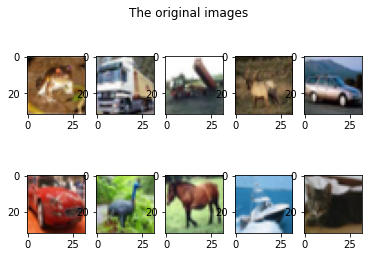

In [111]:
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X_train[i])
plt.suptitle('The original images')
plt.show()

In [117]:
datagen=tf.keras.preprocessing.image.ImageDataGenerator(samplewise_center=True,
                                                       samplewise_std_normalization=True)

In [118]:
train_generator=datagen.flow(X_train,y_train,shuffle=False)

In [119]:
X_batch,y_batch=train_generator.next()

In [120]:
X_batch=X_batch/max(abs(X_batch.min()),X_batch.max())
X_batch=(X_batch*127+127).astype('uint8')

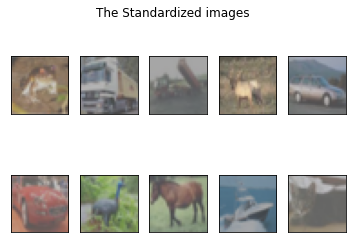

In [121]:
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.gca().axes.yaxis.set_visible(False)
    plt.gca().axes.xaxis.set_visible(False)
    plt.imshow(X_batch[i])
plt.suptitle('The Standardized images')
plt.show()

## Batch Normalization

- 모형의 입력 데이터 -> 정규화되었음
- 모형의 중간 처리 데이터들
-> 정규화되지 않은 데이터들이 만들어지며, 이들이 다시 다음 단계의 입력데이터로 사용됨
-> 중간처리 데이터들의 Normalization을 위한 레이어: BatchNormalization()

- BatchNormalization()레이어를 포함하는 모형
-> BatchNormalization() 이전 레이어에서는 절편을 계산할 필요X
: 정규화 결과 어차피 0으로 변형될 것이기 때문
-> 활성화는 정규화 이후에 실행하는 것이 효과적
 : 특히 relu의 경우는 0을 기준으로 함수 형태 바뀜

In [122]:
(X_train,y_train),(X_test,y_test)=tf.keras.datasets.mnist.load_data()

In [123]:
model2=tf.keras.models.Sequential()

In [124]:
model2.add(tf.keras.layers.Conv2D(input_shape=(28,28,1),
                                 kernel_size=[3,3],
                                 filters=32,
                                 use_bias=False)) #절편 사용X

In [125]:
model2.add(tf.keras.layers.BatchNormalization())

In [126]:
model2.add(tf.keras.layers.Activation('relu')) #0을 기준으로 함수 형태가 바뀜

# 사전 훈련된 모형 사용 개념도

- 대부분의 경우, 아래 레이어들은 재사용하고 최종 레이어에 가까운 레이어들을 교체
- 방법1: 분류 레이어(=예측 레이어)만 교체
- 방법2: 마지막 단계의이미지 변형 레이어 및 예측 레이어들 교체

## Functional 모형

- 다양한 입력자료와 출력값 모델링 가능
- 함수형 모형이 일반적으로 많이 사용되는 추세

In [127]:
inputs=tf.keras.Input(shape=(32,32,3)) #input 레이어 정의함

In [128]:
hidden=tf.keras.layers.Conv2D(kernel_size=[3,3],
                             filters=32,
                             activation='relu')(inputs) #각 레이어를 함수 인자로 서로 연결

In [129]:
hidden=tf.keras.layers.MaxPool2D(pool_size=(2,2))(hidden)#각 레이어는 다음 레이어의 입력 인자됨

In [130]:
hidden=tf.keras.layers.Conv2D(kernel_size=[3,3],
                             filters=64,
                             activation='relu')(hidden)

In [131]:
hidden=tf.keras.layers.MaxPool2D(pool_size=(2,2))(hidden)

In [132]:
hidden=tf.keras.layers.Conv2D(kernel_size=[3,3],
                             filters=64,
                             activation='relu')(hidden)

In [133]:
hidden=tf.keras.layers.Flatten()(hidden)

In [134]:
hidden=tf.keras.layers.Dense(units=64,activation='relu')(hidden)

In [135]:
outputs=tf.keras.layers.Dense(units=10,activation='softmax')(hidden)#마지막 레이어 지정

In [136]:
#inputs레이어와 outputs레이어를 입력과 출력으로 하는 모형 생성
model=tf.keras.Model(inputs=inputs,outputs=outputs)

# 전이 학습 모형 개발

- 사전 훈련된 모형 재사용
-> 사전 훈련 모형의 이미지 변형 결과를 입력데이터로 하는 새로운 모형 설계
-> 예측(분류)레이어만 다른걸로 교체

## 사전 훈련 모형 다운로드

In [137]:
#이미지 학습 레이어만 다운로드
vgg16=tf.keras.applications.vgg16.VGG16(include_top=False,#Dense레이어를 사용한 분류 레이어는 다운로드X
                                       input_tensor=inputs)

In [138]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

## 이미지 특성을 사용한 분류레이어 추가

- 다운로드한 모형의 output이 추가될 분류 모형들의 input이 됨


In [139]:
vgg16_output=vgg16.output

In [140]:
#다운로드한 모형의 output이 추가될 분류 모형들의 input됨
top_model=tf.keras.layers.Flatten(input_shape=(4,4,512))(vgg16_output)
#input_shape는 다운로드한 모형의 최종output shape 모형임

In [141]:
#분류를 위한Dense레이어들 추가
top_model=tf.keras.layers.Dense(512,activation='relu')(top_model)

In [142]:
top_model=tf.keras.layers.Dropout(0.5)(top_model)

In [143]:
outputs=tf.keras.layers.Dense(10,activation='softmax')(top_model)

## 다운로드한 모형의 input을 inputs로 사용하고, 추가된 분류 모형들의 결과를 outputs로 사용하는 모형 완성

In [144]:
#다운로드한 모형의 input을 inputs로 사용하고, 추가된 분류 모형들의 결과를 ouputs로 사용하는 모형 완성
model=tf.keras.Model(inputs=vgg16.input,outputs=outputs)

## 각 레이어의 학습변수들의 학습 가능성 설정

- 새로이 추가된 레이어의 학습변수들은 훈련가능하도록 그대로 둠
- 다운로드한 레이어의 학습변수들은 훈련 불가능하도록 설정(다운로드한 값들을 그대로 사용)

In [145]:
len(model.trainable_weights)

30

In [146]:
for layer in vgg16.layers:
    layer.trainable=False #가중치고정

In [147]:
len(model.trainable_weights)

4

## 모형 훈련 및 학습 결과

- 학습률 더욱 미세하게 조정 -> 0.0001
- 학습 시간이 오래걸림

ValueError: in user code:

    File "C:\Users\user\anaconda3\lib\site-packages\keras\engine\training.py", line 1820, in test_function  *
        return step_function(self, iterator)
    File "C:\Users\user\anaconda3\lib\site-packages\keras\engine\training.py", line 1804, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\user\anaconda3\lib\site-packages\keras\engine\training.py", line 1792, in run_step  **
        outputs = model.test_step(data)
    File "C:\Users\user\anaconda3\lib\site-packages\keras\engine\training.py", line 1756, in test_step
        y_pred = self(x, training=False)
    File "C:\Users\user\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\user\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_5" is incompatible with the layer: expected shape=(None, 32, 32, 3), found shape=(None, 28, 28)


In [152]:
BATCH_SIZE=32
VALIDATION_SPLIT=0.2

In [153]:
tensorboard=tf.keras.callbacks.TensorBoard(log_dir="D:\myTensorflowDir/cifar10_my")

In [154]:
history=model.fit(x=X_train,y=y_train,batch_size=BATCH_SIZE,epochs=20,
                 validation_split=VALIDATION_SPLIT,
                 callbacks=[tensorboard,
                            tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)])

Epoch 1/20


ValueError: in user code:

    File "C:\Users\user\anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\user\anaconda3\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\user\anaconda3\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\user\anaconda3\lib\site-packages\keras\engine\training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\user\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\user\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_5" is incompatible with the layer: expected shape=(None, 32, 32, 3), found shape=(32, 28, 28)
